<a href="https://colab.research.google.com/github/marcelo-guimaraes/Data-Science/blob/master/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic: Machine Learning from Disaster

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, accuracy_score

In [11]:
titanic = sns.load_dataset('titanic')
print(titanic.shape)
titanic.head()

(891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


Podemos notar que esse dataset possui algumas colunas que repetem as mesmas informações. Como é o caso da coluna `class` com a `pclass`, as colunas `embarked` e `embark_town`, as colunas `survived` e a `alive` e por fim as colunas `alone` e `sibsp`

In [13]:
titanic.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [21]:
#Número de sobreviventes no desastre
titanic['survived'].value_counts()

0    549
1    342
Name: survived, dtype: int64

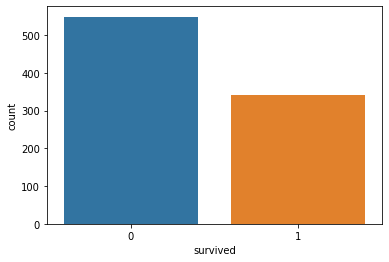

In [20]:
#Visualização do número de sobreviventes
sns.countplot(titanic['survived'])

### Visualizar o número de sobreviventes de acordo com as colunas `who`, `sex`, `pclass`, `sibsp`, `parch` e `embarked`

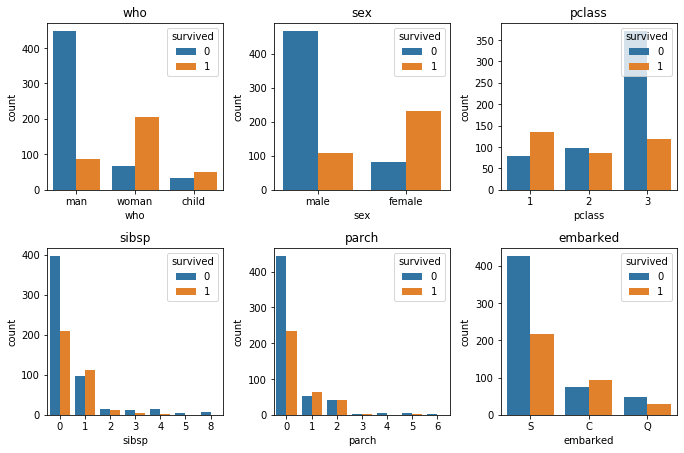

In [30]:
cols = ['who', 'sex', 'pclass', 'sibsp', 'parch', 'embarked']

n_rows = 2
n_cols = 3


fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.2,n_rows*3.2))

for r in range(0,n_rows):
    for c in range(0,n_cols):  
        
        i = r*n_cols+ c #index para varrer o vetor 'cols'      
        ax = axs[r][c] #Mostra a posição de cada subplot
        sns.countplot(titanic[cols[i]], hue=titanic["survived"], ax=ax)
        ax.set_title(cols[i])
        ax.legend(title="survived", loc='upper right') 
        
plt.tight_layout()

In [34]:
#Taxa de sobrevivência por sexo
titanic.groupby('sex')[['survived']].mean()

,survived
sex,
female,0.742038
male,0.188908


Pode-se notar que 74,2% das mulheres sobreviveram enquanto apenas 18,9% dos homens tiveram a mesma sorte

In [35]:
#Taxa de sobrevivência considerando o sexo e a classe
titanic.pivot_table('survived', index = 'sex', columns = 'class')

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


Observamos também que as mulheres da primeira classe foram quase todas salvas. Enquanto se ela estivesse na terceira classe, sua chance de ser salva seria em torno de 50%

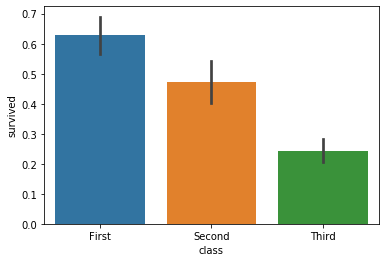

In [36]:
#visualização da taxa de sobrevivência por classe
sns.barplot(x='class', y='survived', data=titanic)

In [39]:
#Taxa de sobrevivência por sexo, idade e classe 
age = pd.cut(titanic['age'], [0,18,80])
titanic.pivot_table('survived', index = ['sex',age], columns = 'class')

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

### Finalizada a Análise Exploratória, começarei com o Processamento dos Dados

In [40]:
titanic.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

Percebemos aqui  que algumas colunas apresentam Missing Values, os quais teremos que tratar, uma vez que os modelos de Machine Learning não funcionam com dados faltantes

In [0]:
#Irei excluir algumas colunas reduntantes, como foram identificadas no início do código. Também excluirei a coluna 'deck', que tem a maioria de seus dados
#como faltantes, e as colunas 'adult_male' e 'who', que não estão presente no dataset original, disponibilizado pelo Kaggle.

titanic = titanic.drop(['deck', 'embark_town', 'alive', 'class', 'alone', 'adult_male', 'who'], axis = 1)

#Também irei excluir as linhas que apresentam dados faltantes nas colunas 'embarked' e 'age'
titanic = titanic.dropna(subset = ['embarked', 'age'])

In [43]:
print(titanic.shape)
titanic.head()

(712, 8)


,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Esse é o DataSet depois de serem removidas as colunas e as linhas com missing values

In [0]:
#Aqui, aplicarei um LabelEncoder "manual", para o DataSet ter todas suas variáveis sendo numéricas
titanic['sex'] = titanic['sex'].map({'female':1, 'male':0}).astype(int)
titanic['embarked'] = titanic['embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)

In [47]:
print(titanic.dtypes)
titanic.head()

survived      int64
pclass        int64
sex           int64
age         float64
sibsp         int64
parch         int64
fare        float64
embarked      int64
dtype: object


,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,0,22.0,1,0,7.2500,0
1,1,1,1,38.0,1,0,71.2833,1
2,1,3,1,26.0,0,0,7.9250,0
3,1,1,1,35.0,1,0,53.1000,0
4,0,3,0,35.0,0,0,8.0500,0


Pronto, o DataSet já está com todas as variáveis como numéricas e já podemos prepará-lo para aplicar o modelo de ML

In [0]:
y = titanic.survived
titanic.drop(['survived'], axis = 1, inplace = True).copy()

In [61]:
print(titanic.shape)
print(y.shape)

(712, 7)
(712,)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(titanic, y, test_size = 0.3)

Dados já divididos para treino e teste. Agora aplicarei o StandardScale, para que tenhamos uma padronização de magnitude, dessa forma, nenhum feature irá dominar outro por conta de sua escala

In [0]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Agora irei usar uma função com diversos modelos de Machine Learning, para que dessa forma possamos escolher qual é o melhor

In [0]:
def modelos(X_train, X_test):

  #Logistic Regression
  from sklearn.linear_model import LogisticRegression
  log = LogisticRegression(random_state = 0)
  log.fit(X_train, y_train)
  
  #KNeighborsClassifier
  from sklearn.neighbors import KNeighborsClassifier
  knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
  knn.fit(X_train, y_train)

  #Support Vector Machine com Kernel Linear
  from sklearn.svm import SVC
  svc_lin = SVC(kernel = 'linear', random_state = 0)
  svc_lin.fit(X_train, y_train)

  #Support Vector Machine com Kernel rbf
  from sklearn.svm import SVC
  svc_rbf = SVC(kernel = 'rbf', random_state = 0)
  svc_rbf.fit(X_train, y_train)

  #Naive Bayes
  from sklearn.naive_bayes import GaussianNB
  gauss = GaussianNB()
  gauss.fit(X_train, y_train)

  #DecisionTreeClassifier
  from sklearn.tree import DecisionTreeClassifier
  tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
  tree.fit(X_train, y_train)

  #RandomForestClassifier
  from sklearn.ensemble import RandomForestClassifier
  forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
  forest.fit(X_train, y_train)

  #print model accuracy on the training data.
  print('[0]Logistic Regression Training Accuracy:', log.score(X_train, y_train))
  print('[1]K Nearest Neighbor Training Accuracy:', knn.score(X_train, y_train))
  print('[2]Support Vector Machine (Linear Classifier) Training Accuracy:', svc_lin.score(X_train, y_train))
  print('[3]Support Vector Machine (RBF Classifier) Training Accuracy:', svc_rbf.score(X_train, y_train))
  print('[4]Gaussian Naive Bayes Training Accuracy:', gauss.score(X_train, y_train))
  print('[5]Decision Tree Classifier Training Accuracy:', tree.score(X_train, y_train))
  print('[6]Random Forest Classifier Training Accuracy:', forest.score(X_train, y_train))
  
  return log, knn, svc_lin, svc_rbf, gauss, tree, forest
 

In [71]:
model = modelos(X_train, X_test)

[0]Logistic Regression Training Accuracy: 0.8172690763052208
[1]K Nearest Neighbor Training Accuracy: 0.8634538152610441
[2]Support Vector Machine (Linear Classifier) Training Accuracy: 0.7730923694779116
[3]Support Vector Machine (RBF Classifier) Training Accuracy: 0.8554216867469879
[4]Gaussian Naive Bayes Training Accuracy: 0.7931726907630522
[5]Decision Tree Classifier Training Accuracy: 0.9879518072289156
[6]Random Forest Classifier Training Accuracy: 0.9718875502008032


### Matriz de confusão e Acurácia:

In [75]:
for i in range(len(model)):
  cm = confusion_matrix(y_test, model[i].predict(X_test))
  ac = accuracy_score(y_test, model[i].predict(X_test))

  print(cm)
  print('Modelo[{}] Acurácia: {}'.format(i,ac))

[[108  21]
 [ 23  62]]
Modelo[0] Acurácia: 0.794392523364486
[[100  29]
 [ 24  61]]
Modelo[1] Acurácia: 0.7523364485981309
[[110  19]
 [ 24  61]]
Modelo[2] Acurácia: 0.7990654205607477
[[113  16]
 [ 30  55]]
Modelo[3] Acurácia: 0.7850467289719626
[[95 34]
 [24 61]]
Modelo[4] Acurácia: 0.7289719626168224
[[104  25]
 [ 27  58]]
Modelo[5] Acurácia: 0.7570093457943925
[[104  25]
 [ 30  55]]
Modelo[6] Acurácia: 0.7429906542056075


Como podemos observar, o modelo Support Vector Machine com o parâmetro Linear se saiu ligeiramente melhor. Entretanto, outros modelos tiveram resultados bem parecidos

### Escolha alguns dados para saber se você teria sobrevivido ou não

In [89]:
#[Classe (1 ao 3), Sexo (0 ou 1), Idade, Irmãos Abordo, Parentes, Valor Pago, Local de Embarque(0 ao 2)]
meus_dados = [[1,0,40,3, 6, 500, 0]]

pred = model[2].predict(meus_dados)
print(pred)

if pred == 0:
  print('Você seria o Jack')
else:
  print('Parabéns, você seria a Rose')

[1]
Parabéns, você seria a Rose
